In [1]:
import os
import torch
torch.manual_seed(int(1e9+7e7+17+3))
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
# %matplotlib widget
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from ilt_data import PNGFolderDataset, tensor_to_image
from ilt_model import DualLithoZernikeRegressor
# torch.multiprocessing.set_start_method('spawn') # extremely slow
# import warnings
# warnings.filterwarnings('ignore', category=UserWarning, message='Torchinductor does not support code generation for complex operators. Performance may be worse than eager.')

In [ ]:
DATASET_ROOT = os.path.join('..', 'dataset', 'train_layouts')
workers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# -------- 3. DataLoader --------
def make_dataloaders(root, batch_size=16, num_zernike=20, split=0.8, workers=1, load_all_to_ram=False):
    dataset = PNGFolderDataset(root, N_zernike=num_zernike, image_size=1024, aberr_max=3.,
                               device=dataset_device, load_all_to_ram=load_all_to_ram, num_threads=workers)
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
    return train_loader, val_loader, dataset

## Load

Aberrations: Z=[-4.9512852e-03 -1.5235330e+00  6.8338931e-02 -2.0413927e-03
  4.0928188e-01  1.8809472e-09 -1.2622718e-02 -1.0122241e+00
 -6.1333994e-04  8.7409794e-02 -8.3820206e-01  7.2876946e-04
  3.3703260e-02 -2.1457700e-01  1.2451756e-01]


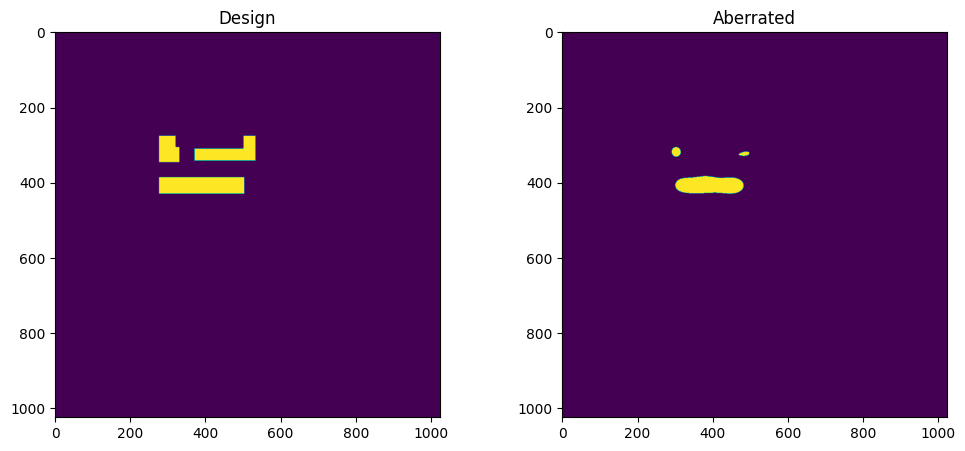

In [4]:
train_loader, val_loader, dataset = make_dataloaders(DATASET_ROOT, batch_size=1, num_zernike=15, workers=0)
a = next(iter(train_loader))
i = 0

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
plt.imshow(dataset.intensity_tensor_to_image(a[0][i][0]))
ax.set_title("Design")
ax = plt.subplot(1,2,2)
plt.imshow(dataset.intensity_tensor_to_image(a[0][i][1]))
ax.set_title("Aberrated")
print(f"Aberrations: Z={a[1][i].cpu().numpy()}")
plt.show()

In [5]:
# -------- 4. Training --------
"mobilenet_v3_small" # 1.5 M / 1.06 m
"mobilenet_v3_large" # 4.2 M / 1.13 m
"efficientnet_b0"    # 4.0 M / 1.45 m
"efficientnet_b2"    # 7.7 M
train_loader, val_loader, dataset = make_dataloaders(DATASET_ROOT, batch_size=8, num_zernike=15, workers=0, load_all_to_ram=False)
warmup_epochs = 1
accumulate_grad_batches = 8
warmup_steps = warmup_epochs * len(train_loader) / accumulate_grad_batches
# model = DualLithoZernikeRegressor("mobilenet_v3_small", num_zernike=15, lr=1e-3, warmup_steps=warmup_steps)
model = DualLithoZernikeRegressor.load_from_checkpoint(
"lightning_logs/Dual Mobilenet_v3 1024 v4/checkpoints/best-model.ckpt")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best-model'
)
logger = TensorBoardLogger(".", name="lightning_logs", version="Dual Mobilenet_v3 1024 v4 small")

trainer = Trainer(max_epochs=100, accelerator="auto", callbacks=[checkpoint_callback],
                  accumulate_grad_batches = accumulate_grad_batches, #gradient_clip_val=1.,
                  logger=logger,
                  precision="16-mixed",
                  # devices=[1],
          )
# trainer.fit(model, train_loader, val_loader)#, ckpt_path="lightning_logs/Dual Mobilenet_v3 1024 v4 small/checkpoints/best-model.ckpt")

/root/anaconda3/envs/SK/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.5.0
/root/anaconda3/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using

In [14]:
# #### CLEAR CACHE #####
# model.cpu()
# from gc import collect
# imgs, z_true = None, None
# litho_imgs, aberr_imgs, restored_imgs = None, None, None
# z_preds = None
# batch = None
# collect()
# torch.cuda.empty_cache()
# collect()

## Inference

In [39]:
from torchvision import transforms
import lithosim_cuda as litho
from fnmatch import fnmatch
from lt_simulator import LTSimulator
import numpy as np

class SignleSampler:
    def __init__(self, root, N_zernike: int = 15, transform=None, amp=1.):
        self.N_zernike = N_zernike
        self.transform = transform
        self.mask_path = None
        self.litho_path = None
        self.amp = amp * np.array([5,5,5, 5.2,2.2,5.5, 10,10,10., 12,1.45,2.95,2.95,17,60])
        self.sim = LTSimulator(device=device)

        self.filenames = []
        for path, subdirs, files in os.walk(root):
            for name in files:
                ext = '.jpg'
                if fnmatch(name, f'*{ext}'):
                    if name == 'grid'+ext:
                        self.litho_path = os.path.join(path, name)
                    elif name == 'grid_mask'+ext:
                        self.mask_path = os.path.join(path, name)
                    else:
                        self.filenames.append(os.path.join(path, name))
        self.filenames.sort()

    def __len__(self):
        # return len(self.filenames)
        return self.N_zernike
    
    def __call__(self, idx):
        # img_path = self.filenames[idx]

        zernike_coeffs = torch.zeros(self.N_zernike, device=device)
        zernike_coeffs[idx] += self.amp[idx]

        design_img = litho.load_image(self.mask_path).to(device)
        # litho_img = litho.load_image(self.litho_path).to(design_img.device)
        litho_img = self.sim.run_lithosim(design_img)[0]
        # aberrated_img = litho.load_image(img_path).to(design_img.device)
        aberrated_img = self.sim.run_lithosim(design_img, zernike_coeffs=zernike_coeffs)[0]
        if self.transform is not None:
            design_img = self.transform(design_img)
            litho_img = self.transform(litho_img)
            aberrated_img = self.transform(aberrated_img)

        # img_name = '.'.join(os.path.basename(img_path).split('.')[:-1])
        # zernike_coeffs = torch.zeros(self.N_zernike, device=litho_img.device)
        # idx, coef = int(img_name.split('_')[-2]), float(img_name.split('_')[-1])
        # if idx < self.N_zernike:
        #     zernike_coeffs[idx] += coef

        imgs = torch.cat([design_img, litho_img, aberrated_img], dim=0) # 3 x H x W
            
        return imgs, zernike_coeffs
    
    def intensity_tensor_to_image(self, intensity):
        return tensor_to_image(litho.mask_threshold(intensity, self.sim.config.threshold))

image_size=1024
transform = transforms.Compose([
            torch.compile(transforms.Resize((image_size, image_size))),
        ])
dataset = SignleSampler('../../model/grid_data/', transform=transform)

Aberrations: Z=[5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


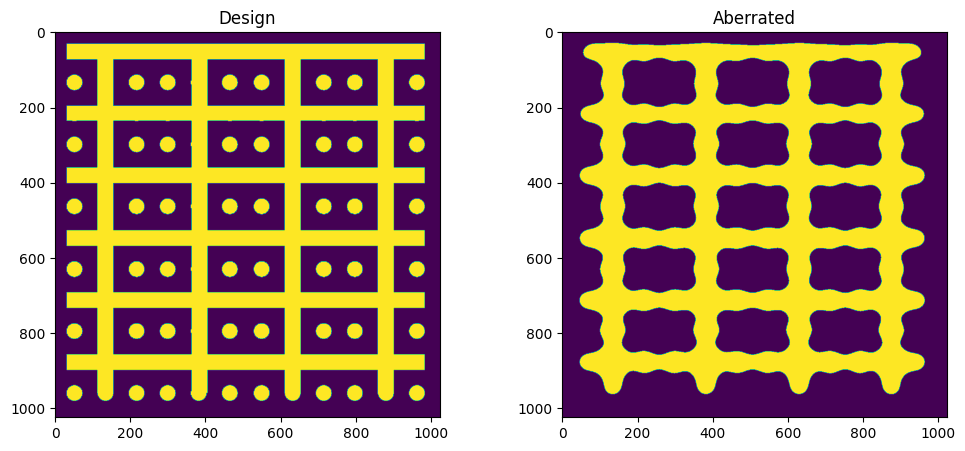

In [40]:
a = dataset(0)

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
plt.imshow(dataset.intensity_tensor_to_image(a[0][0]))
ax.set_title("Design")
ax = plt.subplot(1,2,2)
plt.imshow(dataset.intensity_tensor_to_image(a[0][1]))
ax.set_title("Aberrated")
print(f"Aberrations: Z={a[1].cpu().numpy()}")
plt.show()

In [41]:
b = [dataset(i) for i in range(len(dataset))]
imgs = torch.stack([sample[0] for sample in b]).to(device)
z_true = torch.stack([sample[1] for sample in b]).to(device)

In [42]:
litho_aberr_imgs = imgs[:, 1:]
with torch.no_grad():
    z_preds, z_rev_preds = model(litho_aberr_imgs)

    design_imgs, litho_imgs, aberr_imgs = torch.split(imgs, 1, dim=1) # [B, 3, H, W] -> [B, (1, 1, 1), H, W]

    modelled_imgs = model.sim.run_lithosim(design_imgs, zernike_coeffs=z_preds)
    reconstructed_imgs = model.sim.run_lithosim(aberr_imgs, zernike_coeffs=z_rev_preds)

Aberrations: Z=[5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Preds=[ 0.00372932 -0.12856929  0.566982    0.12668665  0.12016265 -0.35898748
 -0.08073147 -0.37712973 -0.34675273 -0.29860365  0.23763587 -0.1245909
 -0.17207736 -0.17749737 -0.06000528] Inverse=[ 3.3212569e+00 -2.0185567e-01 -3.9383376e-01  1.6348965e+00
  2.3478666e-01 -4.7404885e-01  2.3049143e-01  2.6556084e-01
 -3.5863001e-02 -2.8452629e-01 -3.1666793e-03 -4.7573519e-01
 -2.0546596e+00  1.9339464e+00 -2.8670669e+00]


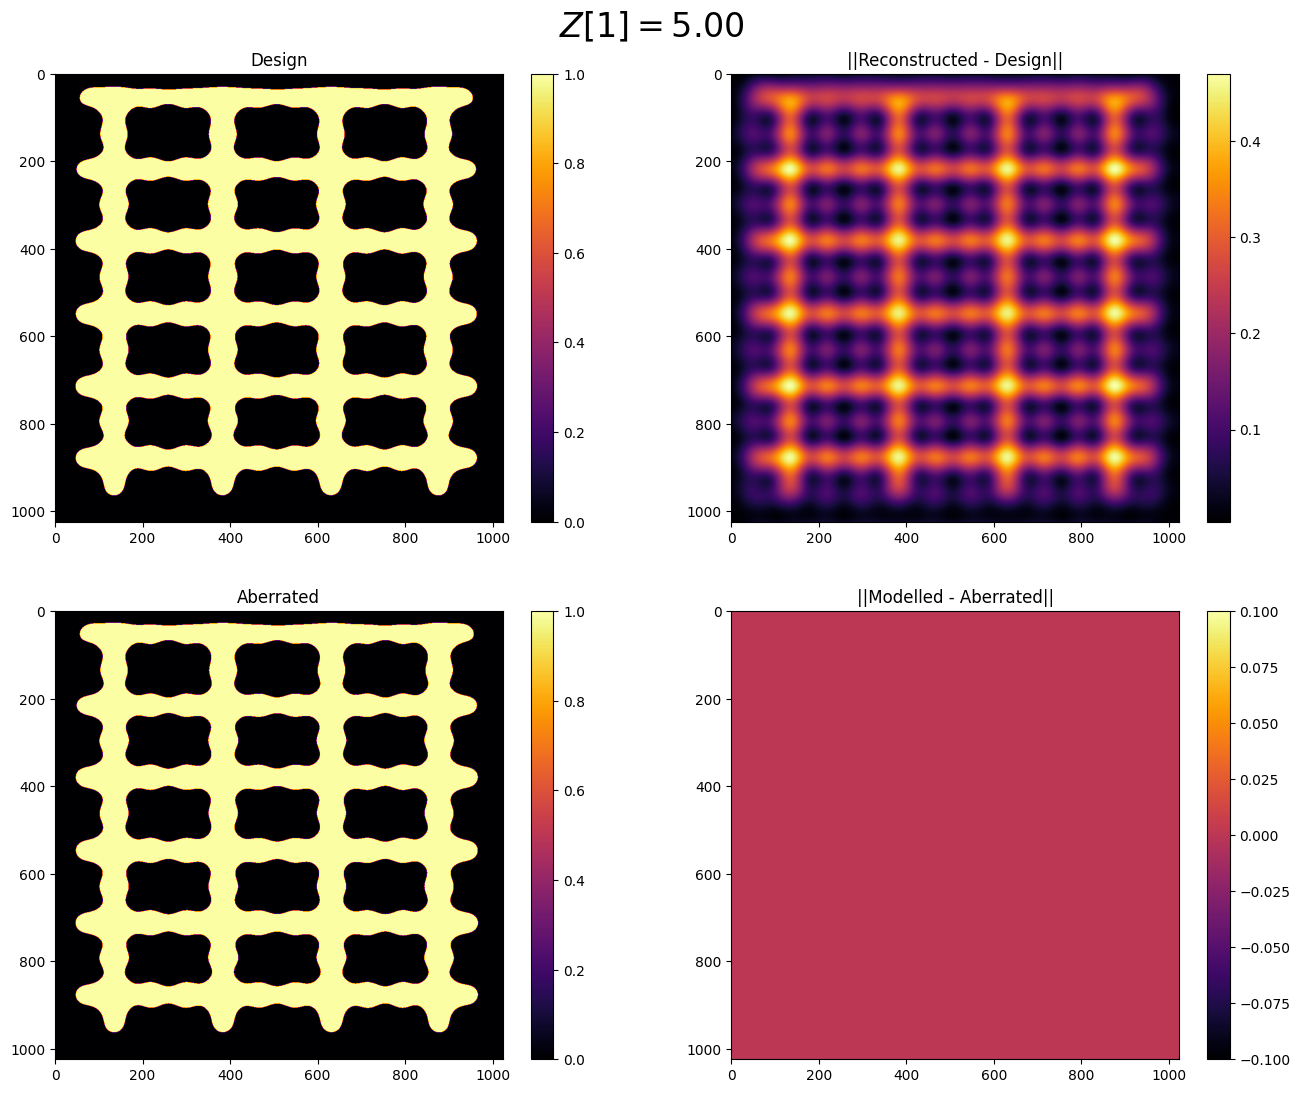

Aberrations: Z=[0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Preds=[ 0.07835267  0.8882934  -0.24013416  0.1141566   0.42445782 -0.23200363
  0.02480498  0.14988425  0.6214236  -0.29820904 -0.18466045 -0.04602171
 -0.32609677  0.0175318  -0.00990483] Inverse=[ 3.9165401  -0.616842    0.23580986  2.0505972  -0.1030802  -0.73070264
  0.5954909   0.35774556 -0.5904523  -0.59748     0.19912428 -0.35483605
 -2.5253894   1.4309936  -2.6153245 ]


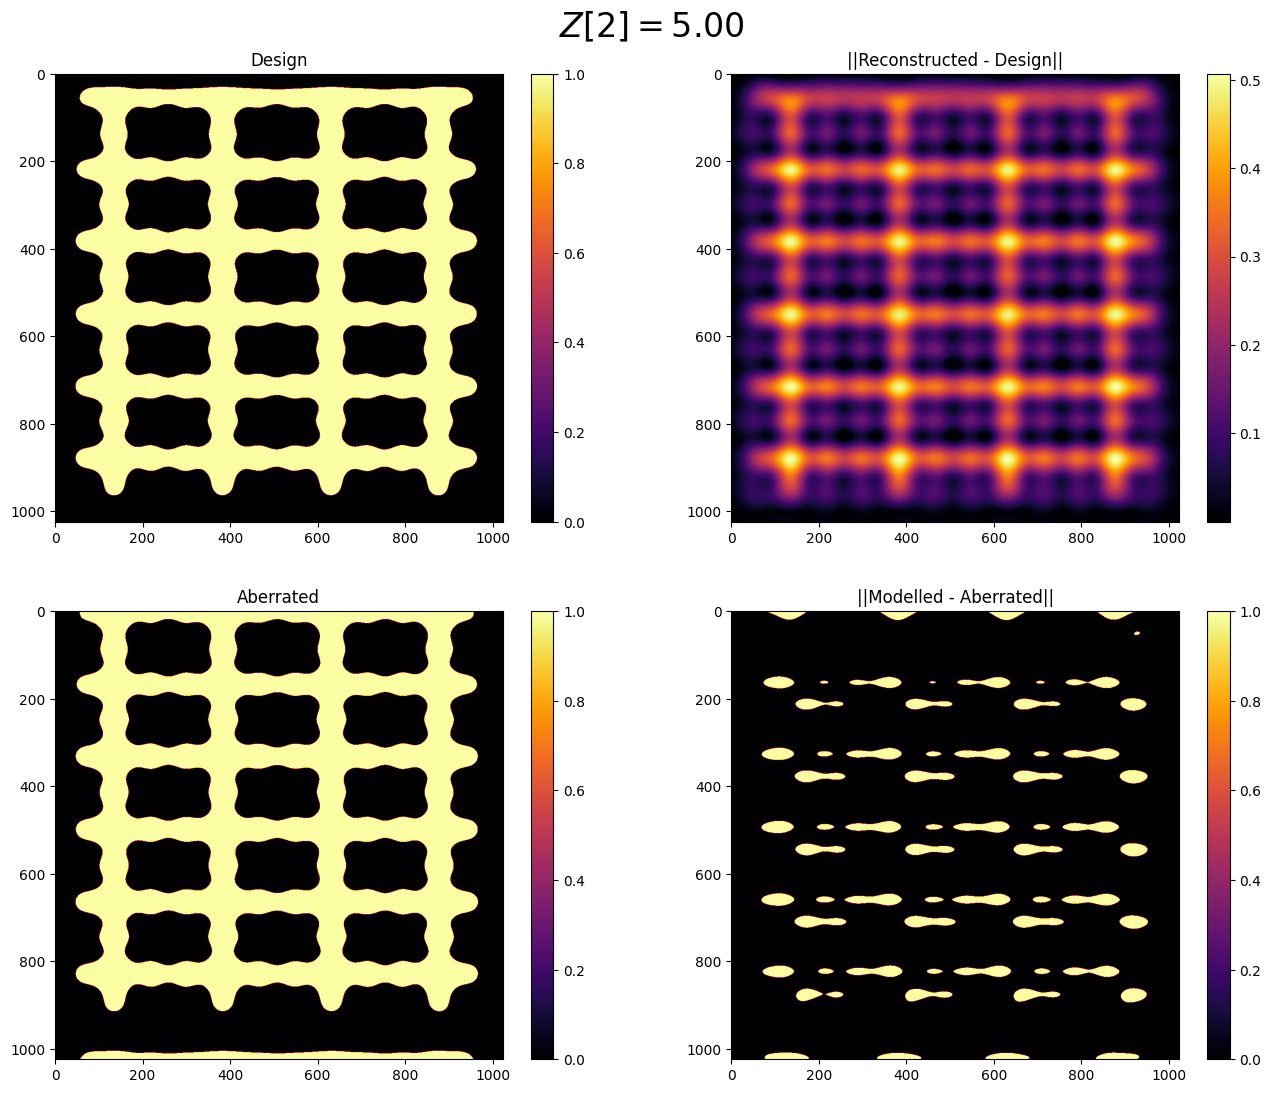

Aberrations: Z=[0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Preds=[ 0.05618844 -0.02114972  0.5592476  -0.3806217   0.23251675 -0.08197126
  0.12576726  0.07875009 -0.44850048 -0.26649842  0.18374595 -0.0289057
  0.37549868 -0.06011304 -0.32361037] Inverse=[ 2.8701177   0.17994574 -0.3969398   1.519376    0.39255482 -0.24700817
  0.18783644 -0.01351011 -0.12021826 -0.16131835 -0.07807897 -0.01067456
 -1.9231809   1.2674648  -2.0921755 ]


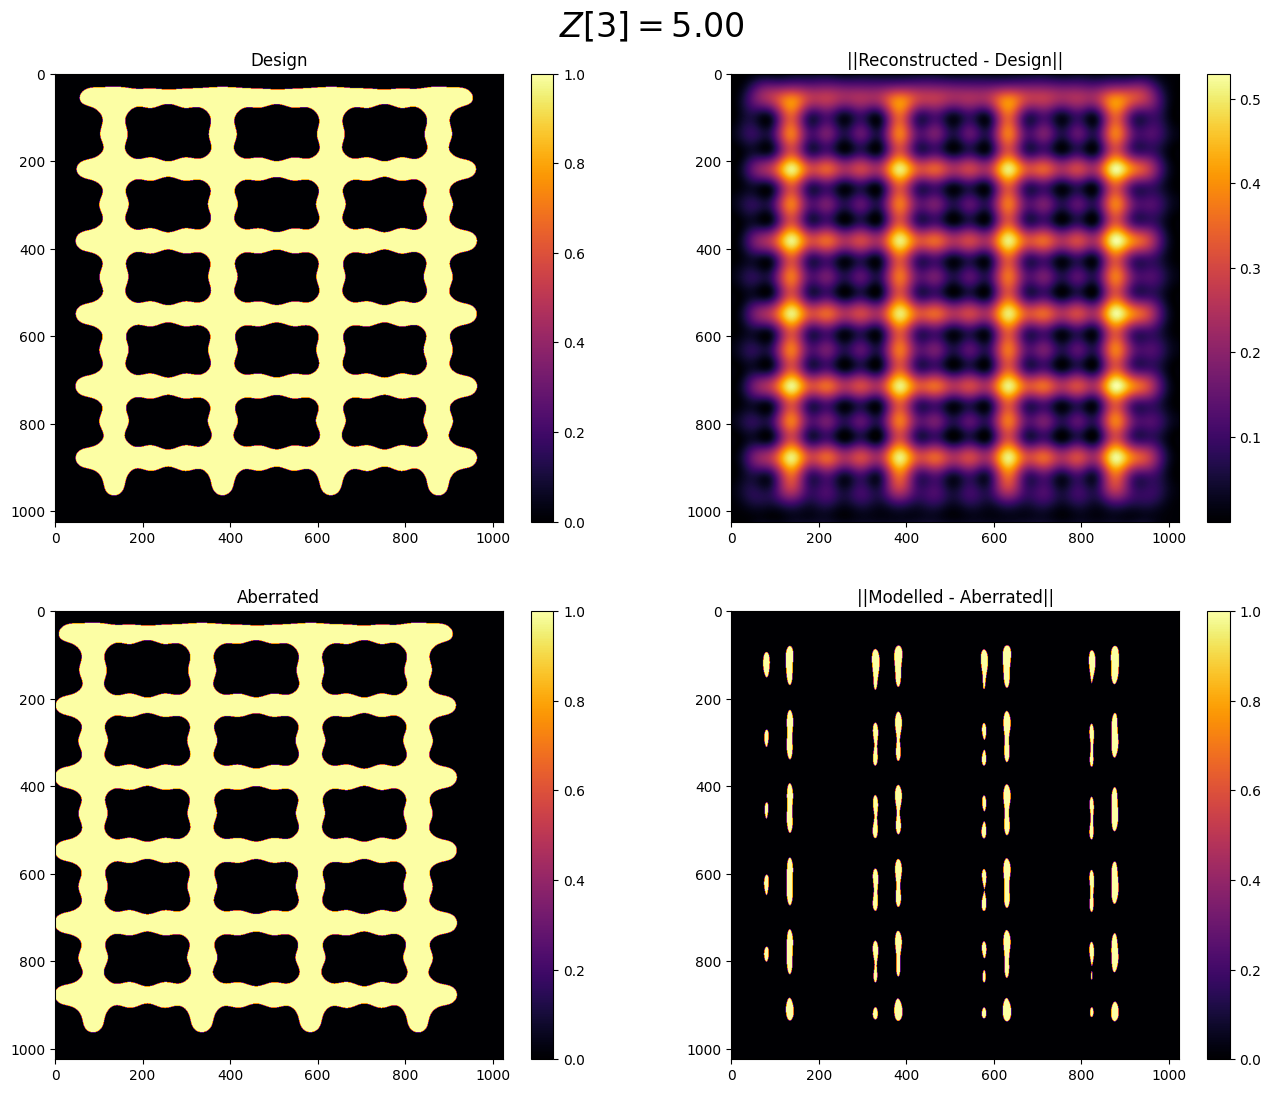

Aberrations: Z=[0.  0.  0.  5.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ] Preds=[ 0.00334994 -0.02785482  0.09352097  0.06136579 -0.07417856 -0.36346212
 -0.0704919   0.03758352 -0.06367338 -0.11786134  0.13952474 -0.00434034
 -0.36648974 -0.08360314  0.02807181] Inverse=[ 3.5398653   0.07224143 -0.21255435  0.78873     0.30517882 -0.2887465
  0.3645131   0.16021913  0.03598426 -0.3299512   0.10794957 -0.24295813
 -0.98890316  2.0564446  -2.374219  ]


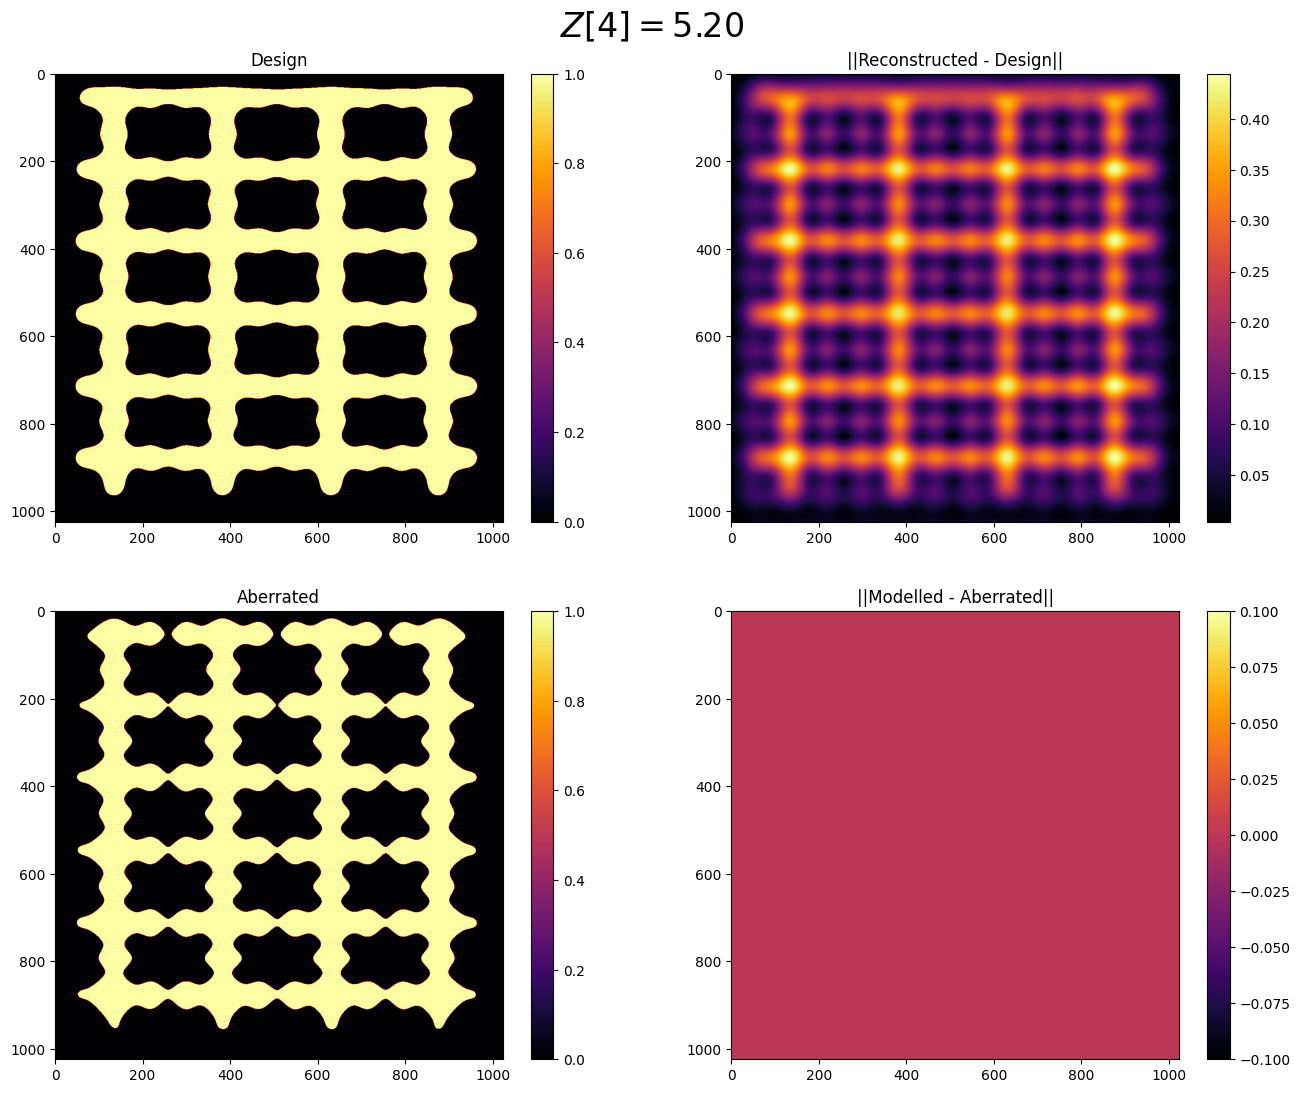

Aberrations: Z=[0.  0.  0.  0.  2.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ] Preds=[ 0.02807432  0.04835885 -0.15955819  0.10365023  0.07747474 -0.0982646
 -0.37886605 -0.23403163  0.42438713 -0.05225489  0.16553625 -0.6653766
  0.02364399 -0.08087165 -0.18474871] Inverse=[ 3.7537923  -0.35915634  0.31447884  2.6409855   0.18487121 -0.39593467
  0.20897204  0.38467535 -0.46098316 -0.55624795  0.22373256 -0.15639704
 -2.9482272   1.5570065  -2.8662095 ]


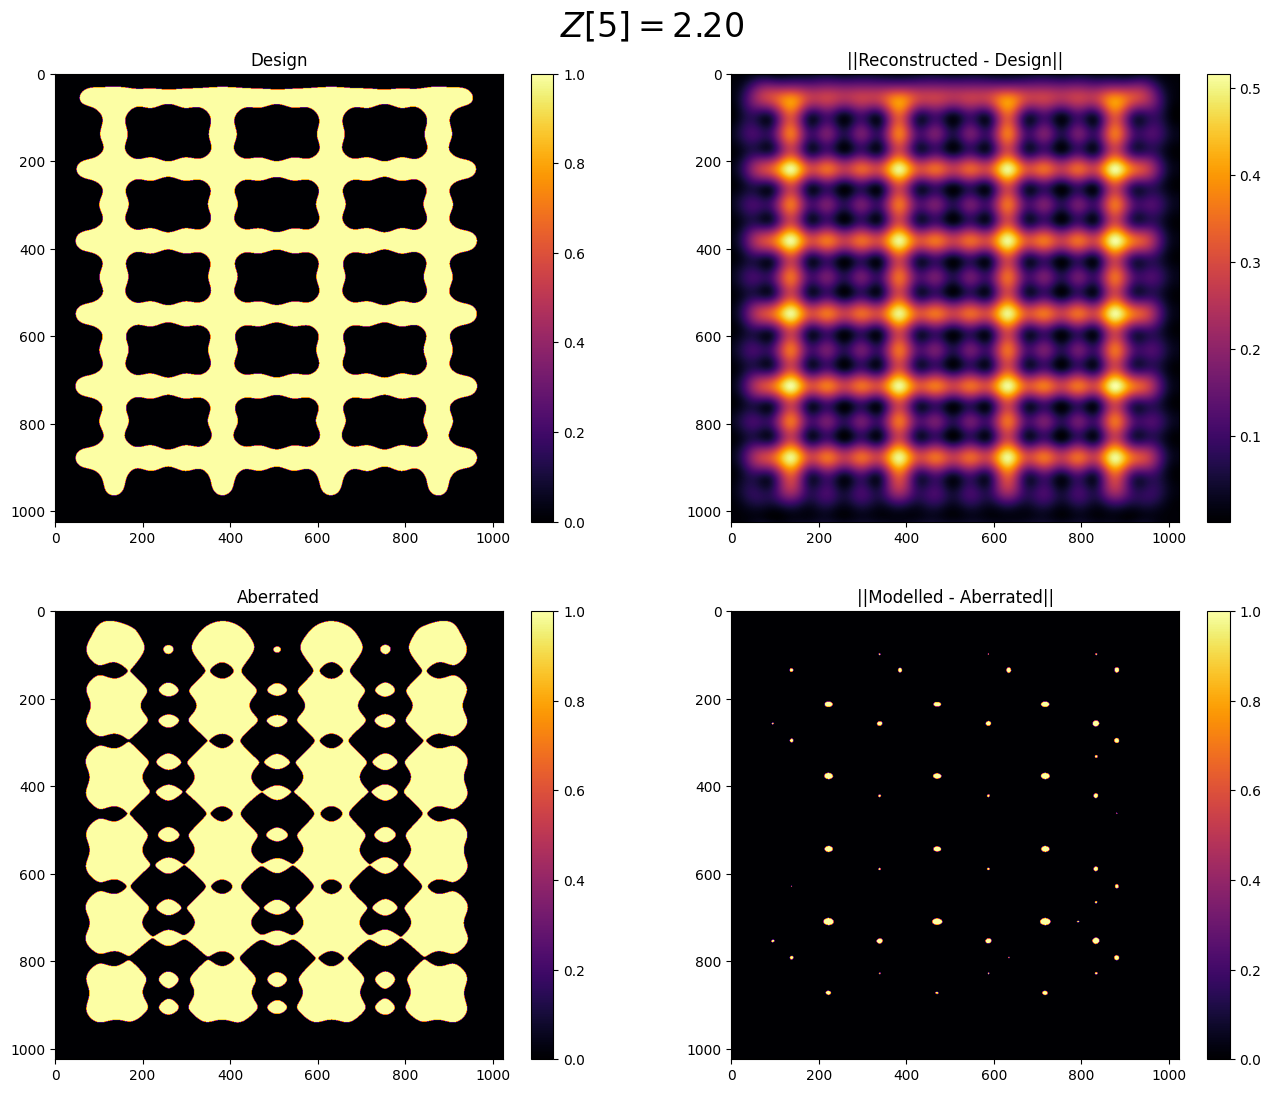

Aberrations: Z=[0.  0.  0.  0.  0.  5.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ] Preds=[ 0.07536751 -0.35095218 -0.20773862 -0.11264752  0.14593634 -0.22492489
 -0.39782354  0.12680136  0.62902856 -0.3121288   0.1651642  -0.13638669
  0.08574121 -0.08556382 -0.14514524] Inverse=[ 3.9259605  -0.0097256   0.40304908  3.3138614   0.15607454 -0.4155503
  0.26530397  0.10925173 -0.51169467 -0.7754748   0.05652089 -0.37750685
 -3.4454312   1.2695334  -3.209639  ]


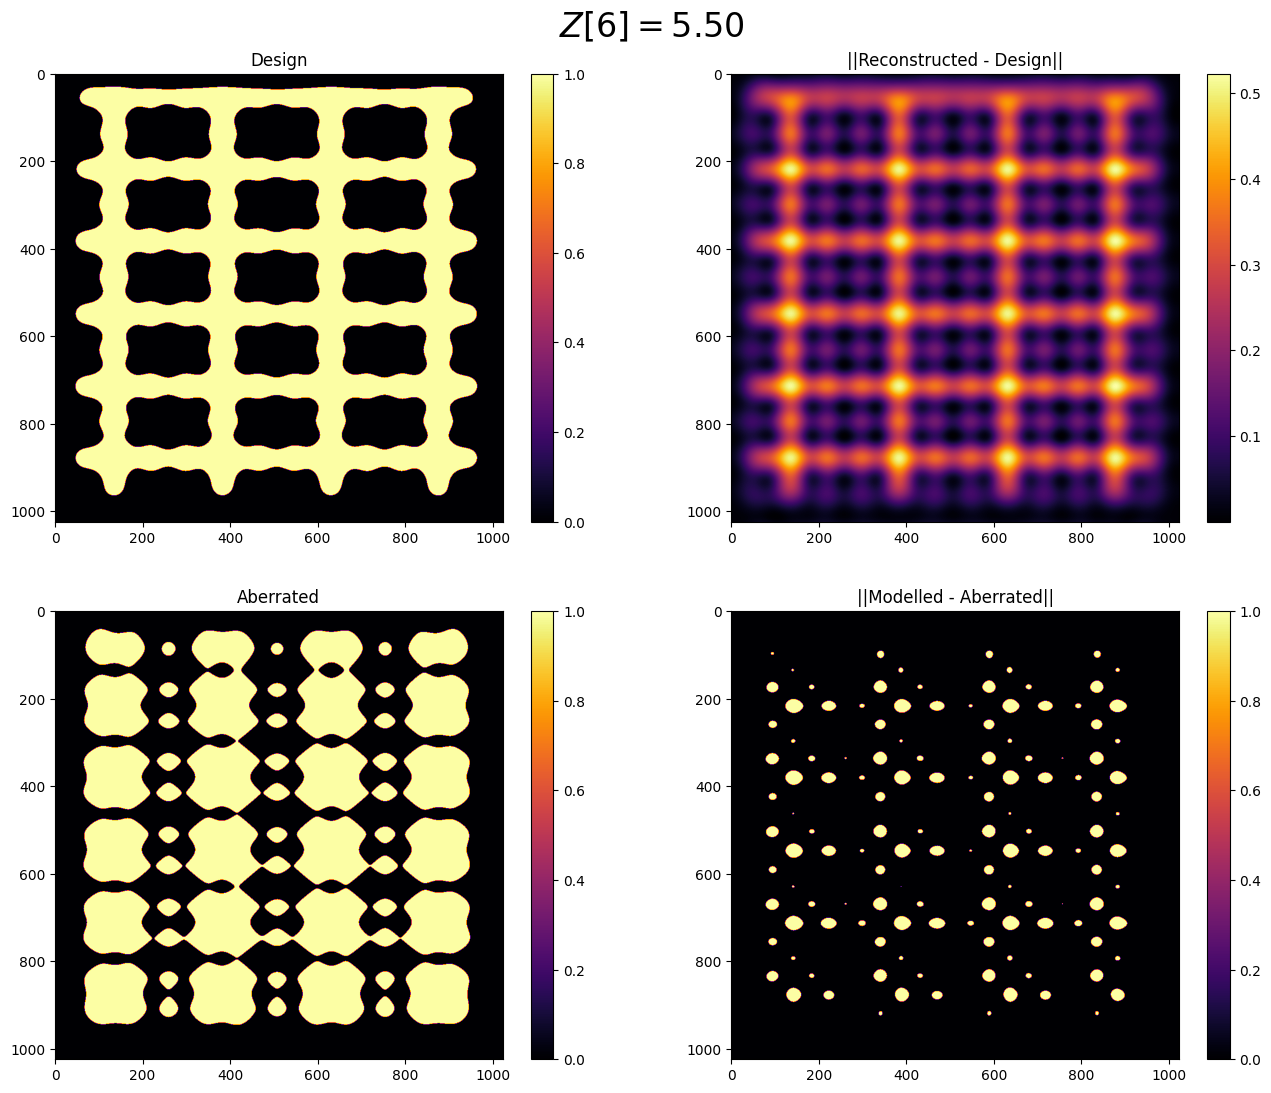

Aberrations: Z=[ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.] Preds=[ 0.01912212  0.10925835 -0.14005035  0.21478619 -0.2796515   0.26875508
 -0.6264613   0.2520776  -0.06839287  0.52831256  0.28187668 -0.03628113
 -0.22059546 -0.00641288  0.01620521] Inverse=[ 3.3246677  -0.23448244 -0.15587324  2.3239493   0.11732438 -0.53559494
  0.2261096   0.14428964 -0.33183217 -0.48079002  0.232386   -0.27612653
 -2.6390955   1.0988377  -2.1544342 ]


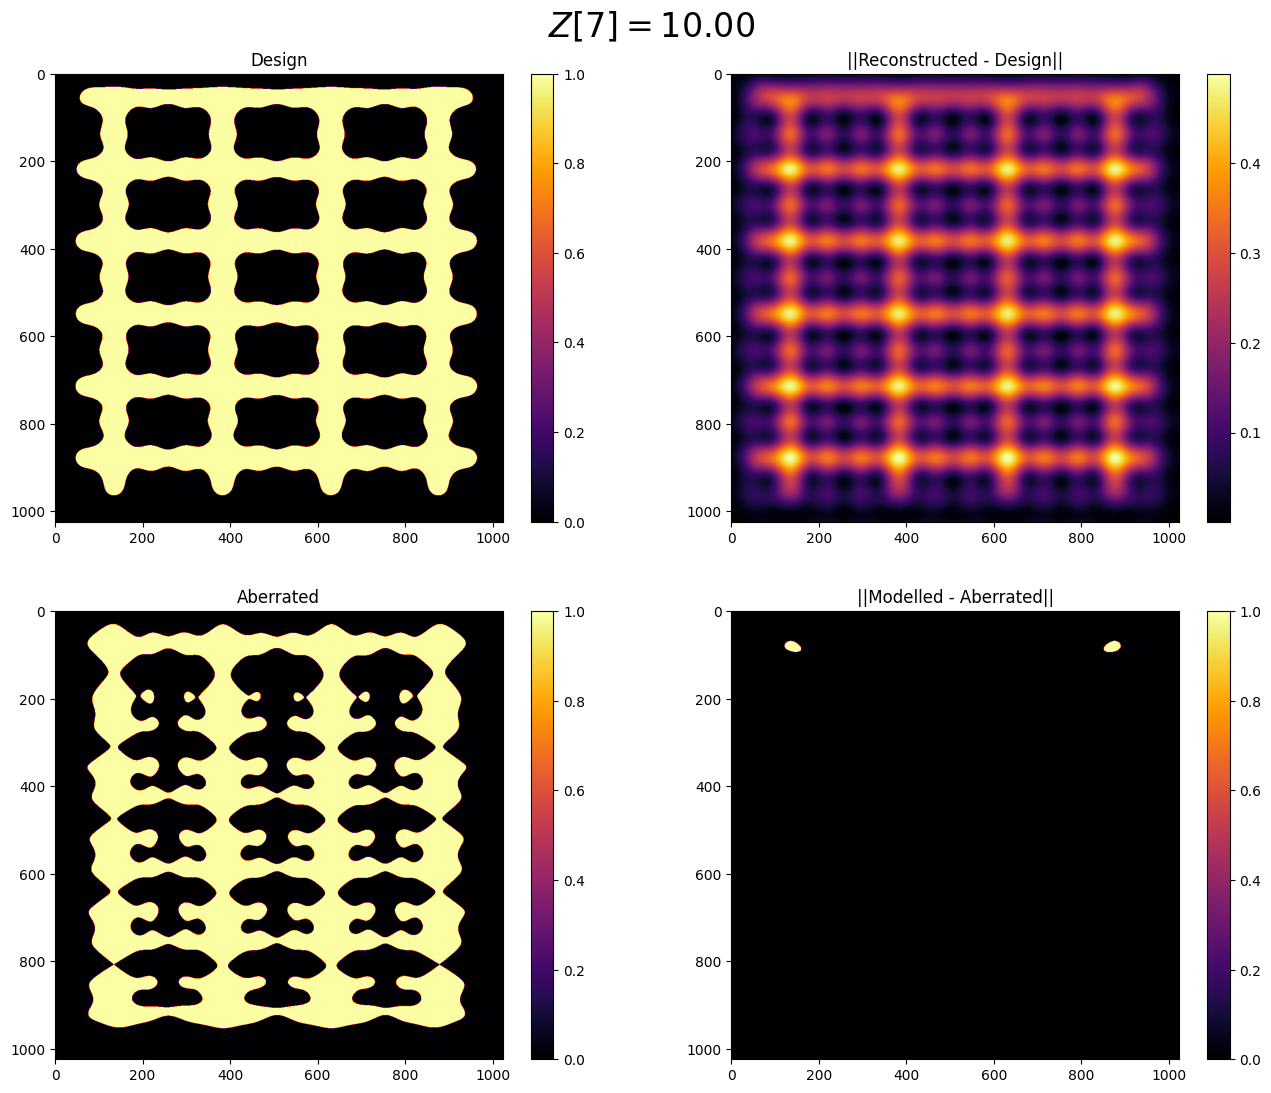

Aberrations: Z=[ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.] Preds=[ 0.04143699  0.7378506  -0.48362067  0.11949097  0.10100427  0.00941678
  0.18863283 -0.0298288   0.08296253  0.24582854  0.16664624  0.02621173
 -0.23140484 -0.13959722  0.12462234] Inverse=[ 2.8094554  -0.5378129   0.24570355  1.3561684   0.22708605 -0.58821815
  0.39583844  0.26310247 -0.3430414  -0.25438482 -0.09011644  0.00301722
 -1.4831363   0.85671055 -1.7342113 ]


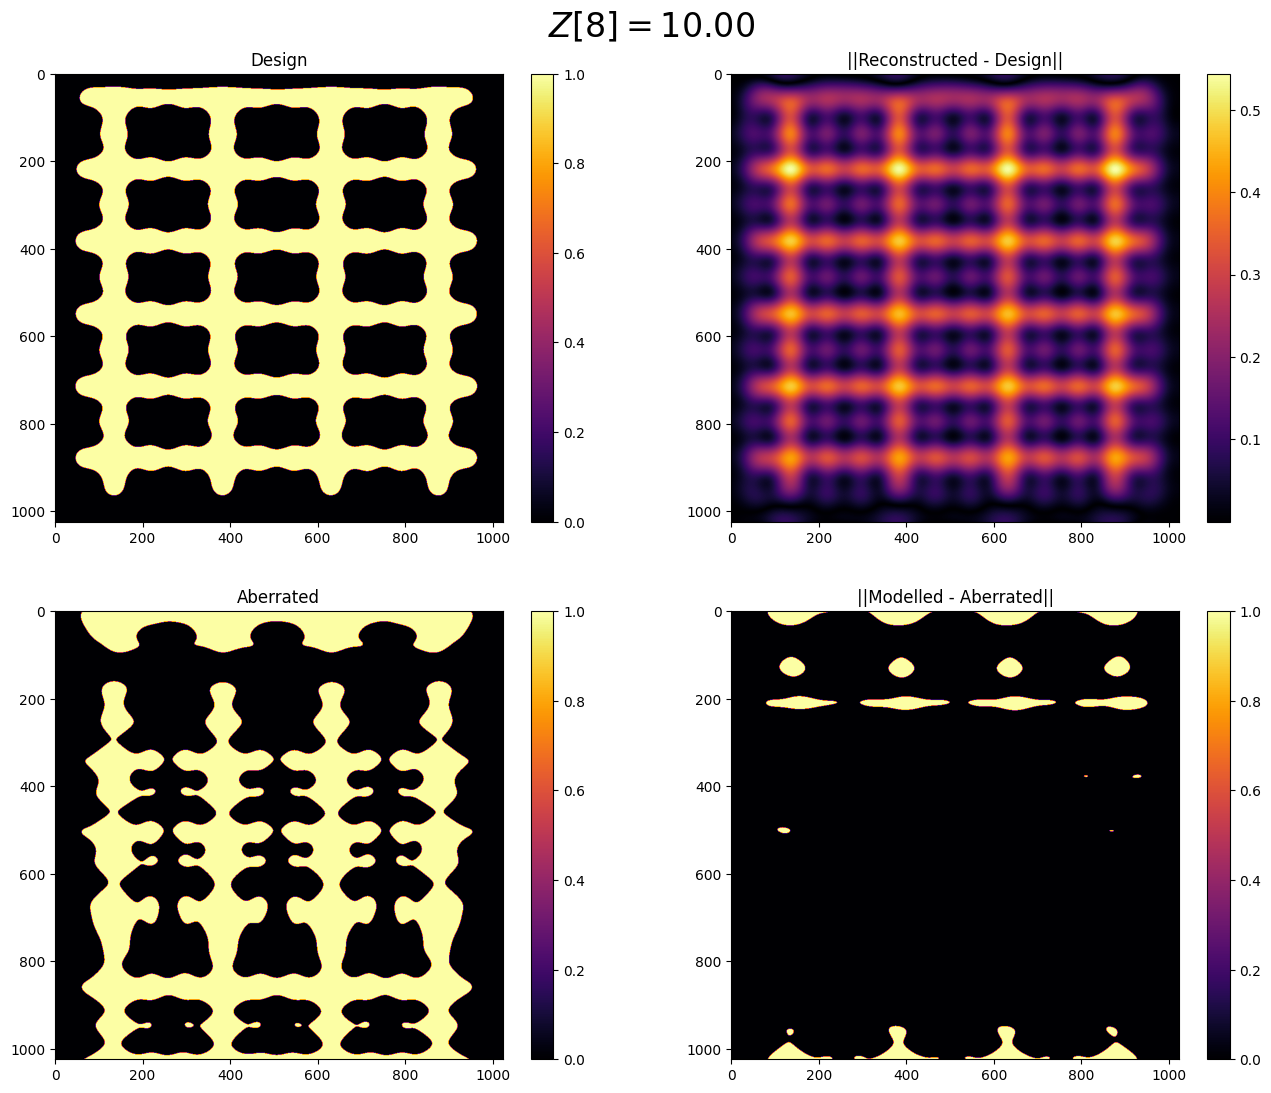

Aberrations: Z=[ 0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.] Preds=[ 0.03921559  0.09463188 -1.5586964  -0.37964788  0.19277021  0.08906753
  0.40924826  0.3485062  -1.0662183  -0.15187763  0.1542154   0.3305694
  0.67688096 -0.08858326 -0.52855843] Inverse=[ 2.6786082   0.1838242  -0.23783118  0.65160054  0.41564584 -0.5164549
  0.40962976  0.34290347 -0.21823609  0.0290039  -0.09812227 -0.0175018
 -0.914989    1.5448647  -1.2662368 ]


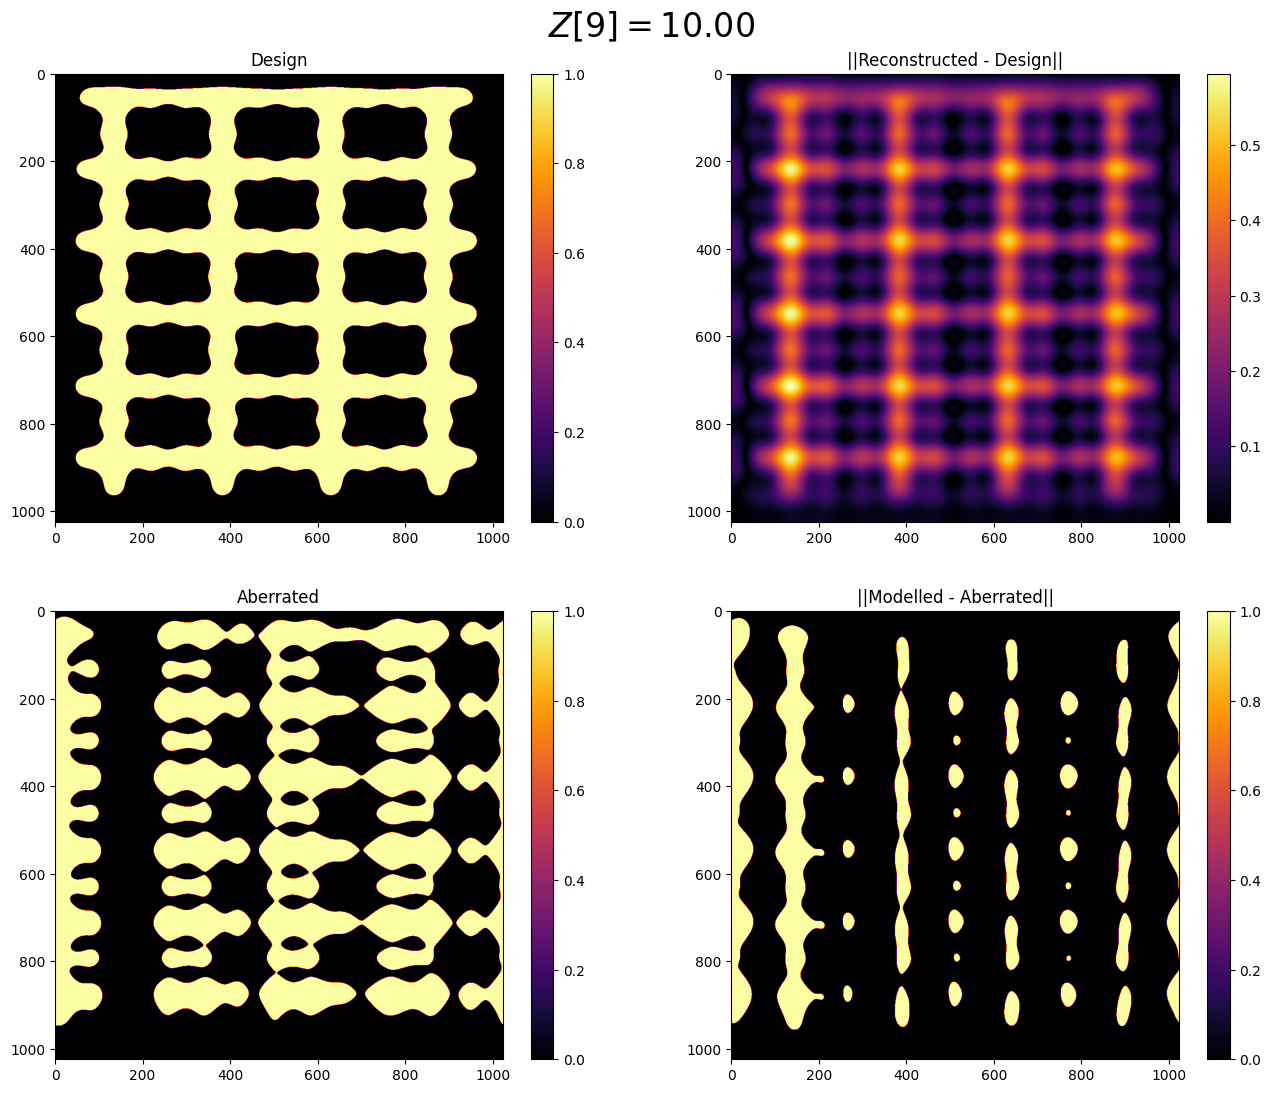

Aberrations: Z=[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 12.  0.  0.  0.  0.  0.] Preds=[ 0.05845096  0.06325419 -0.82671475 -0.16118257 -0.26781863 -0.24007624
 -0.15609036  0.09889382 -0.05216351 -0.6094702  -0.14582667  0.2874072
 -0.23736295 -0.10677276 -0.46901816] Inverse=[ 3.0949802  -0.24822634 -0.12825632  0.8943264   0.01225153 -0.62002355
  0.51099694  0.5147257  -0.5195951  -0.3119314   0.12556015 -0.09738744
 -0.8316854   0.92796016 -1.5698078 ]


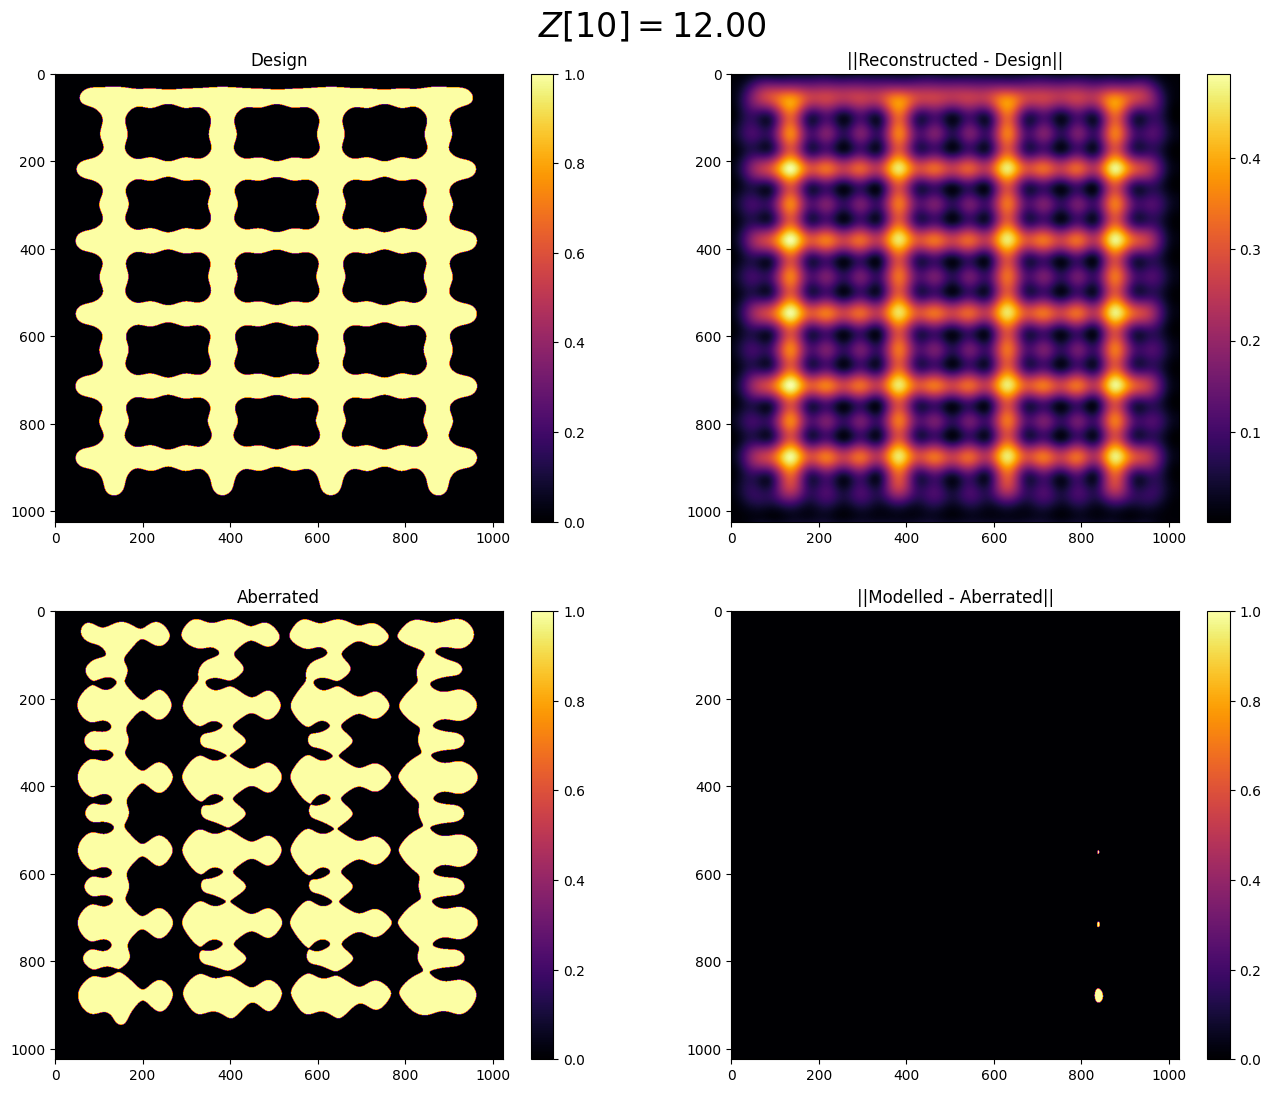

Aberrations: Z=[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.45 0.   0.   0.
 0.  ] Preds=[ 0.00879897 -0.24728072 -0.0531985   0.02934105 -0.11757813 -0.00913482
 -0.49049175 -0.10135279  0.23245981  0.2098124   0.17306209 -0.65657455
  0.17565766  0.15240717  0.26580104] Inverse=[ 4.111908   -0.2036321   0.13534293  2.4213595   0.17659302 -0.43399698
  0.41782242  0.15391025 -0.28588068 -0.46508583  0.10704675 -0.30402458
 -2.7512276   1.6837698  -2.8696642 ]


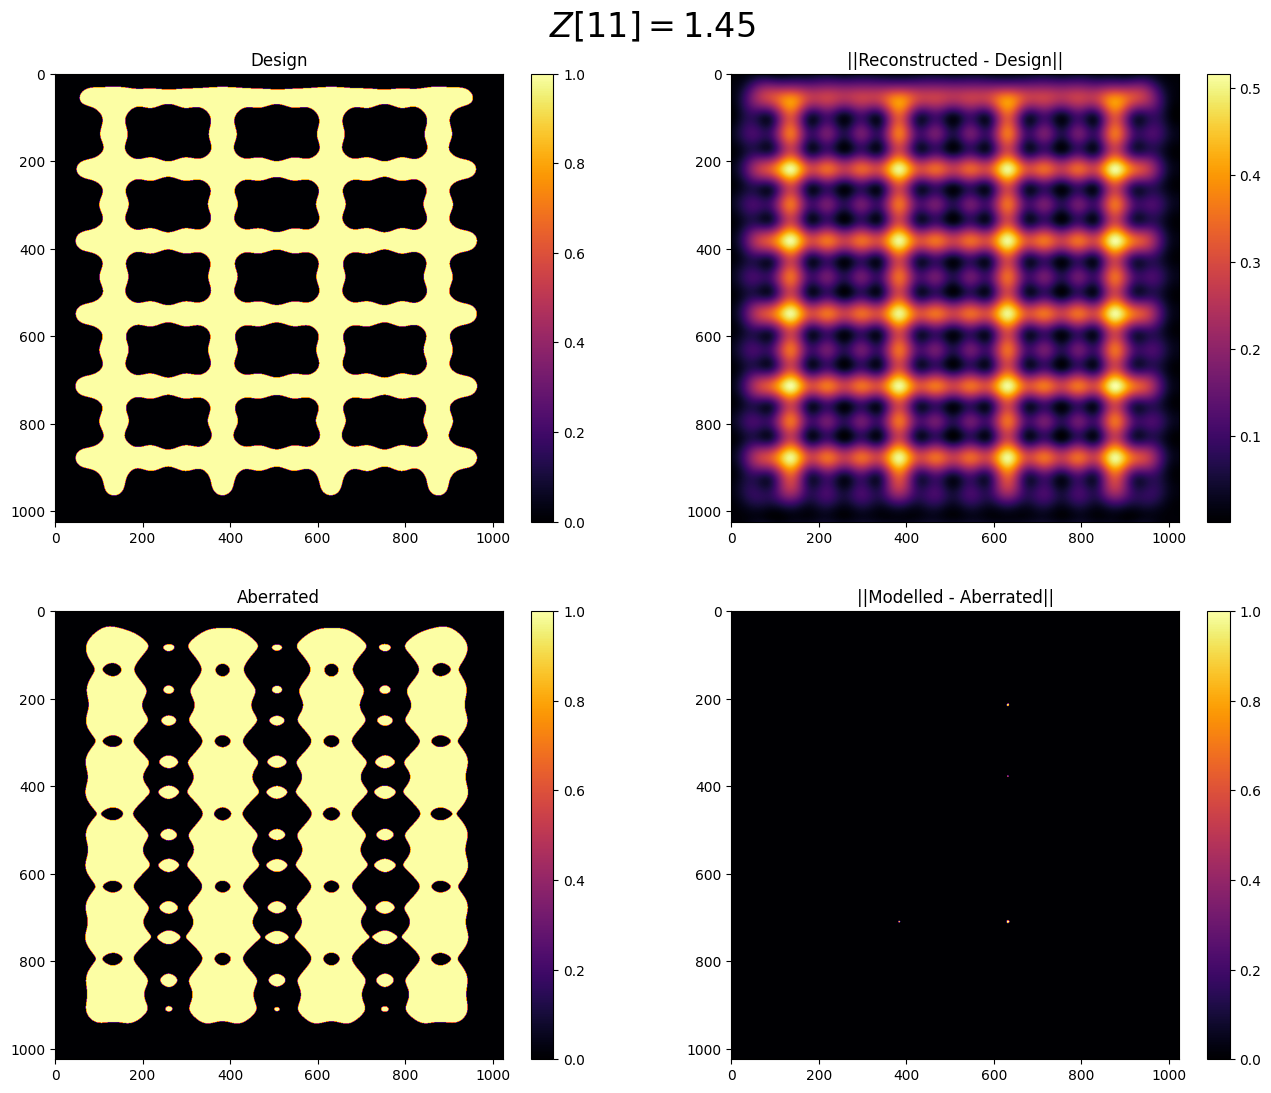

Aberrations: Z=[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.95 0.   0.
 0.  ] Preds=[-0.00646416 -0.13653864  0.04611345 -0.1594423  -0.17536528 -0.37754527
  0.28700727 -0.4026858  -0.35117474  0.0849224   0.04139435  0.01240543
  0.06758781  0.2893219  -0.1003628 ] Inverse=[ 3.4869053  -0.31765637 -0.14912197  1.0756316   0.08132856 -0.47903565
  0.3829922   0.10189024 -0.02091695 -0.09794014 -0.09104107 -0.14291015
 -1.2755653   1.7922688  -2.2979417 ]


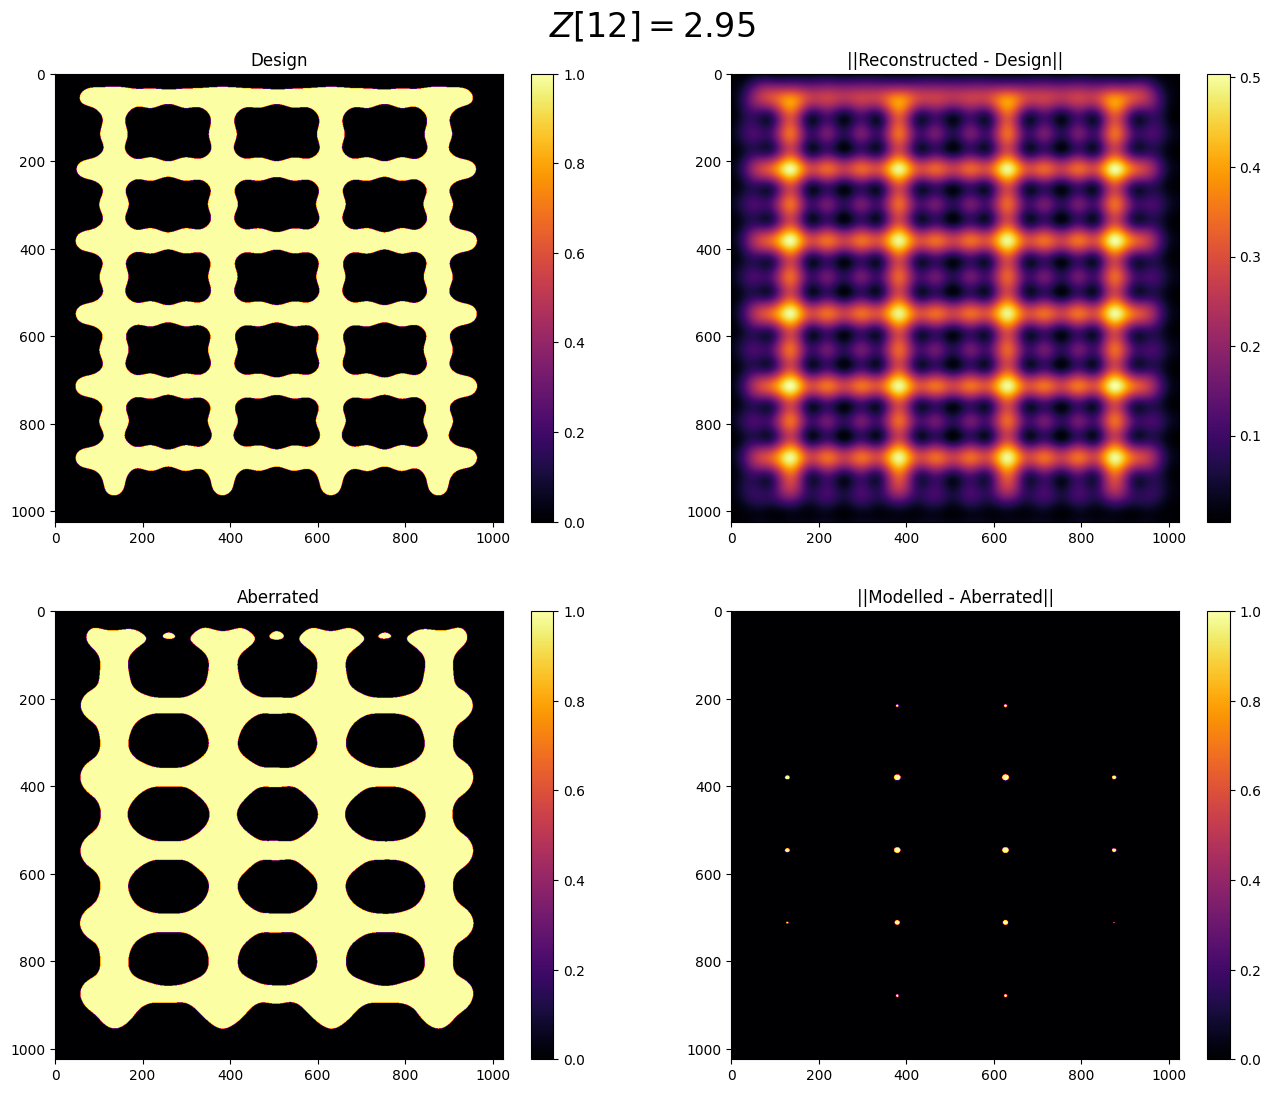

Aberrations: Z=[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.95 0.
 0.  ] Preds=[-0.03630056 -0.88063014  0.4171493   0.13376163  0.14927895 -0.4048723
 -0.28233474 -0.45677057  0.26300812  0.09526417 -0.11645201 -0.027004
 -0.2986866  -0.29330215 -0.15950258] Inverse=[ 2.1306906   0.39038718  0.24839982  0.15185797 -0.21768834 -0.13015248
  0.0156931  -0.09868859 -0.13251667 -0.15997785  0.15506952 -0.2685881
 -0.2687099   0.64971834 -1.363678  ]


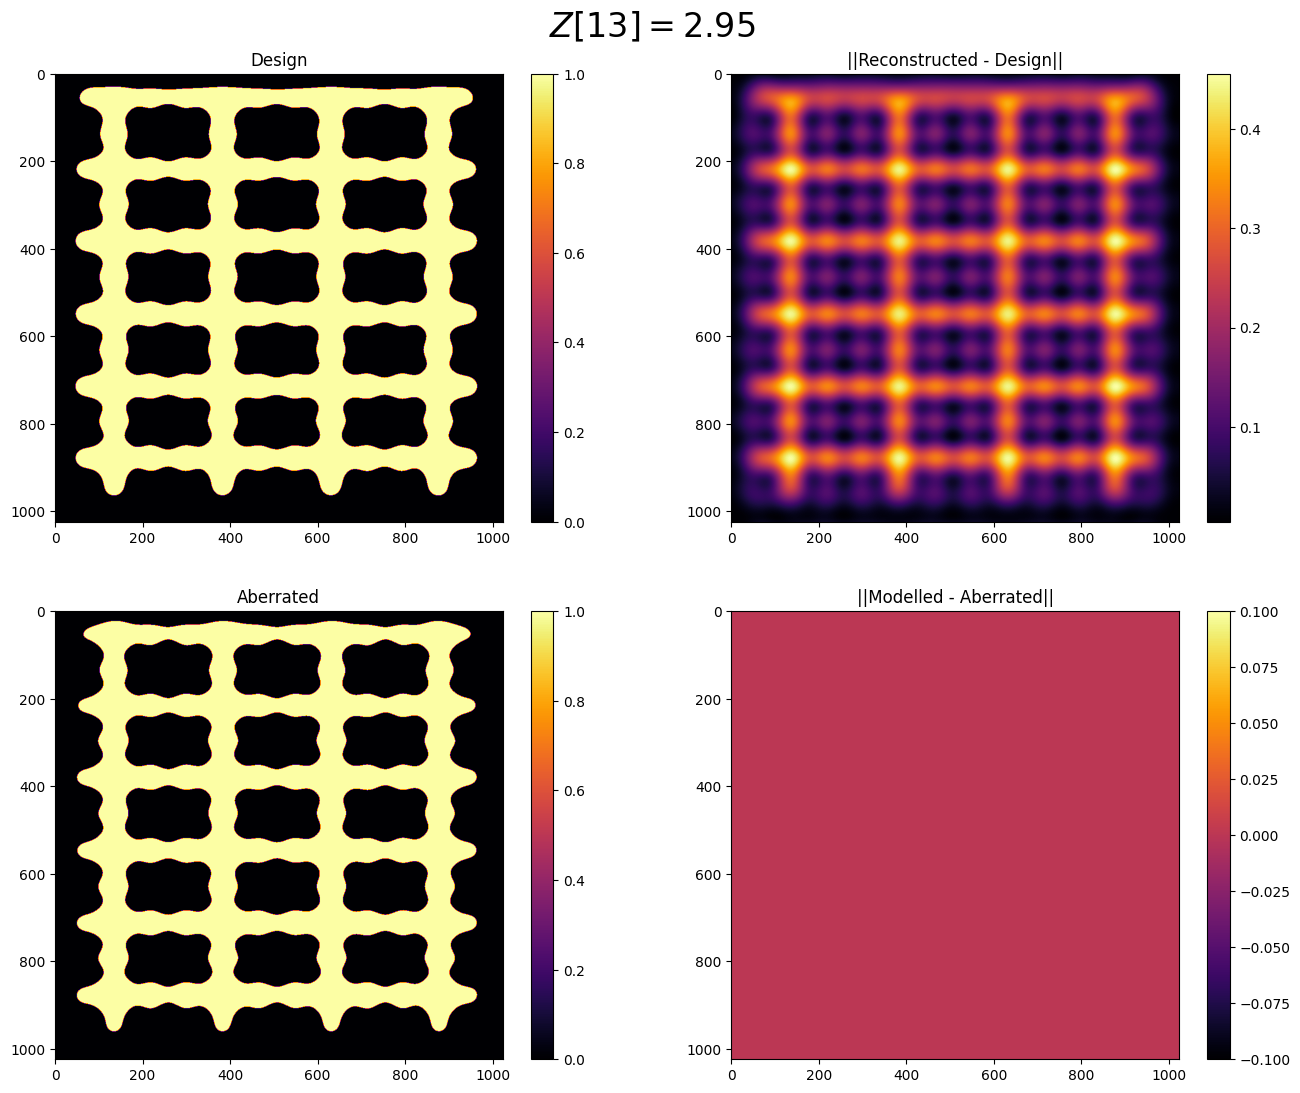

Aberrations: Z=[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 17.  0.] Preds=[-0.01389071 -0.06226103 -0.22718649 -0.21474014 -0.5865254   0.0223598
  0.129478   -0.2326548  -0.26767233  0.13094756  0.04503454 -0.07665876
  0.09193259  0.24843548 -0.12476267] Inverse=[ 2.3032765  -0.37517297 -0.15712471  0.10012008  0.17238422 -0.2140468
  0.14173326  0.2792905   0.02026334 -0.00323004 -0.16846873 -0.24177364
 -0.16138154  0.9598842  -1.3036213 ]


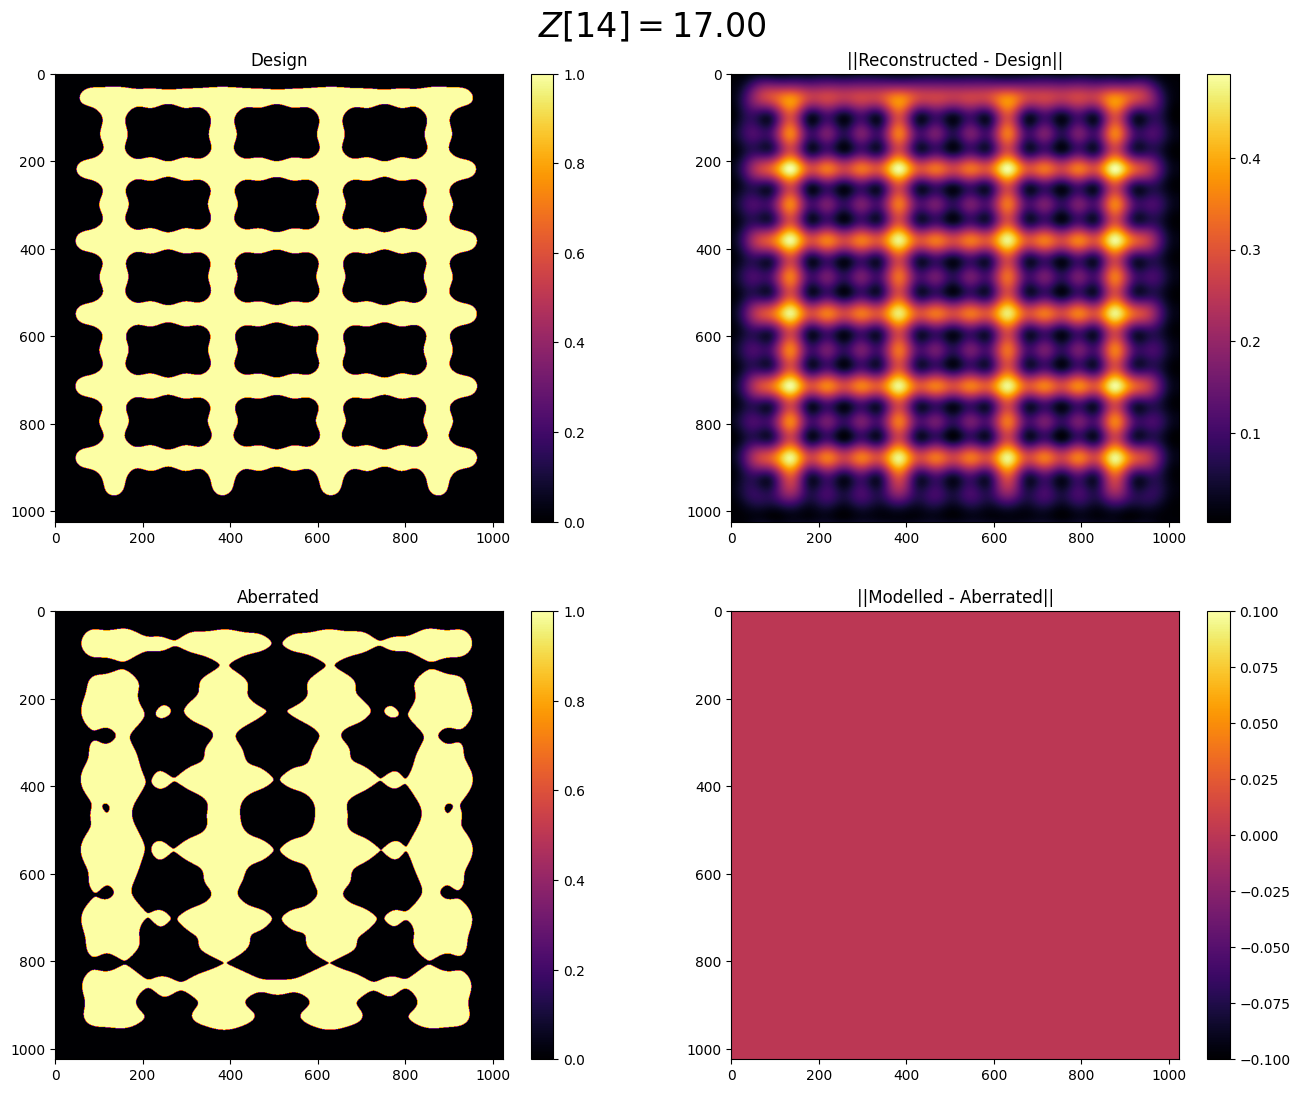

Aberrations: Z=[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 60.] Preds=[ 0.00773773 -0.39050436  0.1213188   0.0519413   0.00638198 -0.5717745
 -0.15233494 -0.23610906 -0.16386229 -0.18830103 -0.07880682 -0.16673544
 -0.31987986 -0.50732327  0.24630782] Inverse=[ 3.5433779   0.15865394 -0.19332483  0.9076432   0.03621221 -0.26449552
  0.25463283 -0.07954078  0.02734513 -0.22922358  0.08323757 -0.34844932
 -1.166262    1.7361294  -2.4016376 ]


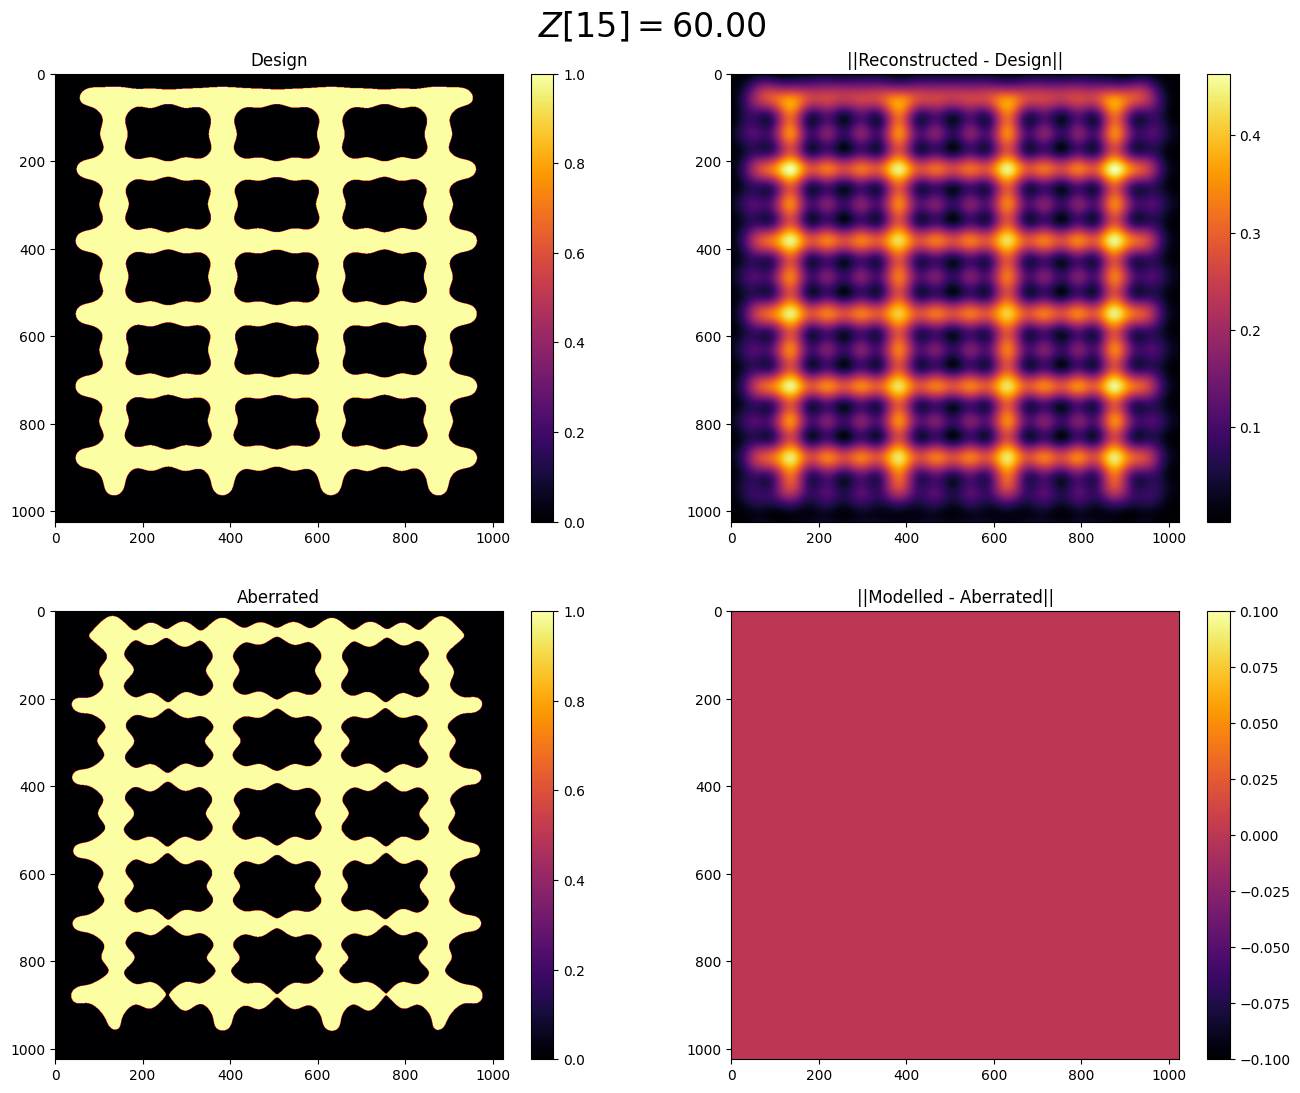

In [51]:
for i in range(imgs.shape[0]):
# dataset.intensity_tensor_to_image
    fig = plt.figure(figsize=(16,16*0.8))
    img = litho_imgs[i]
    z = z_true[i][i].item()
    alter_img = reconstructed_imgs[i]
    ax = plt.subplot(2,2,1)
    plt.imshow(dataset.intensity_tensor_to_image(img), cmap='inferno')
    ax.set_title(f"Design")
    plt.colorbar()

    ax = plt.subplot(2,2,2)
    plt.imshow(tensor_to_image(torch.abs(alter_img-img)), cmap='inferno')
    plt.colorbar()
    ax.set_title(f"||Reconstructed - Design||")

    ax = plt.subplot(2,2,3)
    img = aberr_imgs[i]
    alter_img = modelled_imgs[i]
    plt.imshow(dataset.intensity_tensor_to_image(img), cmap='inferno')
    ax.set_title(f"Aberrated")
    plt.colorbar()

    ax = plt.subplot(2,2,4)
    plt.imshow(dataset.intensity_tensor_to_image(torch.abs(alter_img-img)), cmap='inferno')
    ax.set_title(f"||Modelled - Aberrated||")
    plt.colorbar()

    plt.suptitle(f"$Z[{i+1}]={z:.2f}$", fontsize=24, y=0.93)
    print(f"Aberrations: Z={z_true[i].cpu().numpy()}", 
          f"Preds={z_preds[i].detach().cpu().numpy()}", 
          f"Inverse={z_rev_preds[i].detach().cpu().numpy()}")
    plt.show()